## Transfomer

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn
python3 -m pip install --user imblearn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn\npython3 -m pip install --user imblearn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

## Data定義

In [3]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.26 s, sys: 180 ms, total: 3.44 s
Wall time: 3.48 s


In [4]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx = col.index('Sex')
            if data[idx] == '男':
                data[idx] = 0
            else:
                data[idx] = 1
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    for i in range(len(col)):
        if i == idx:
            continue
        else:
            subjects_info[:,i] = (subjects_info[:,i] - np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [5]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

data_label.shape
data_aal.shape
data_ho.shape

CPU times: user 10.1 s, sys: 34 ms, total: 10.2 s
Wall time: 10.2 s


(616, 140, 110)

In [6]:
#%%time
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [10]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())
    
class Model(nn.Module):    
    def __init__(self,input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer):
        super(Model, self).__init__()
        self.fc   = nn.Linear(input_dim,hidden_dim)
        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=0.1)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,nhead,dropout=0.1,batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x,axis=2)
        x = torch.mean(x,axis=1)
        x = torch.reshape(x, (-1, 1))
        x = self.sigmoid(x)
        return x
    
"""class Model(nn.Module):
    def __init__(self,input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,hidden_dim)
        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=0.)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,nhead,dropout=0.)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc1  = nn.Linear(hidden_dim,1)
        self.fc2  = nn.Linear(time_len,1)
        self.sigmoid = nn.Sigmoid()
        self.time_len = time_len
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, self.time_len))
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1))
        x = self.sigmoid(x)
        return x"""

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

'class Model(nn.Module):\n    def __init__(self,input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer):\n        super(Model, self).__init__()\n        self.fc0  = nn.Linear(input_dim,hidden_dim)\n        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=0.)\n        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,nhead,dropout=0.)\n        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,\n                                                               num_layers=hidden_dim_transformer)\n        self.fc1  = nn.Linear(hidden_dim,1)\n        self.fc2  = nn.Linear(time_len,1)\n        self.sigmoid = nn.Sigmoid()\n        self.time_len = time_len\n        \n    def forward(self,x):\n        x = self.fc0(x)\n        x = self.pos(x)\n        x = self.transformer_encoder(x)\n        x = self.fc1(x)\n        x = torch.reshape(x, (-1, self.time_len))\n        x = self.fc2(x)\n        x = torch.reshape(x, (-1, 

In [11]:
from imblearn.over_sampling import SMOTE

#https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92#%E3%82%AA%E3%83%BC%E3%83%90%E3%83%BC%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AA%E3%83%B3%E3%82%B0
#https://pimientito-handson-ml.hatenablog.com/entry/2019/10/15/014801

In [12]:
def train_model(data,label,epochs=1000,n_splits=5):
    
    epochs = epochs
    seed = 0
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    label_gender = np.array([label[:,1]]).T
    train_all, test, train_all_label, test_label = train_test_split(data,label_gender, train_size = 0.9 ,shuffle=False)
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits)
    test_pred_all = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_all_label[train_index]
        val,   val_label   = train_all[val_index],   train_all_label[val_index]
        
        input_dim  = train.shape[2]
        hidden_dim = 64
        time_len   = train.shape[1]
        nhead      = 4
        output_dim = train_label.shape[1]
        hidden_dim_transformer = 1
        
        sm = SMOTE(random_state=42)
        train, train_label = sm.fit_resample(train.reshape(train.shape[0],-1), train_label)
        train = train.reshape(train.shape[0],time_len,input_dim)
        train_label = train_label.reshape(train_label.shape[0],-1)
        
        train_dataset = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset = MyDataset(val,val_label)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model = Model(input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer).to(device)
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(model.parameters())

        def compute_loss(y, t):
            return criterion(y, t)

        def train_step(x,t):
            model.train()
            preds = model(x)
            loss = compute_loss(preds, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss, preds

        def val_step(x,t):
            model.eval()
            preds = model(x)
            loss = compute_loss(preds, t)    
            return loss, preds

        def test_step(x):
            model.eval()
            preds = model(x)
            return preds
        
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.
            
            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t)
                train_loss += loss.item()
                
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t)
                val_loss += loss.item()
                
            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            """if early_stopping >= val_loss:
                early_stopping = val_loss
                model_path = '../02_data_analysis/model/model_gender.pth'
                torch.save(model.state_dict(), model_path)
                save_epochs = epoch+1"""
            
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        #model.load_state_dict(torch.load(model_path))
        #print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.grid()
        plt.show()
        
        
        train_pred = []
        train_label = []
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = train_step(x,t)
            train_pred.append(preds)
            train_label.append(t)
            
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        plt.scatter(train_label[:,0],np.array(train_pred[:,0]))
        plt.show()
        print(np.mean(train_label[:,0]))
        print(np.corrcoef(train_label[:,0],np.array(train_pred[:,0])))
        
        plt.scatter(val_label[:,0],np.array(val_pred[:,0]))
        plt.show()
        print(np.corrcoef(val_label[:,0],np.array(val_pred[:,0])))
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_all.append(test_pred)
    return np.array(test_pred_all),test_label

Kfold: 1 ::: epoch: 100, loss: 0.22445718505803278, val loss: 0.6685462296009064
Kfold: 1 ::: epoch: 200, loss: 0.10468995395828695, val loss: 0.9518902897834778
Kfold: 1 ::: epoch: 300, loss: 0.06064289063215256, val loss: 1.1862728297710419
Kfold: 1 ::: epoch: 400, loss: 0.03681649059495505, val loss: 1.3980973362922668
Kfold: 1 ::: epoch: 500, loss: 0.03135479592225131, val loss: 1.7494312524795532


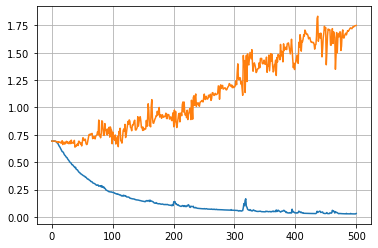

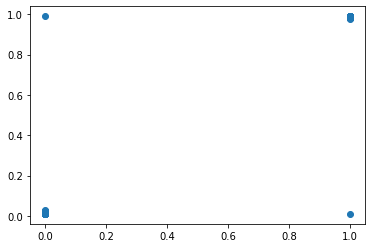

0.5
[[1.         0.99249251]
 [0.99249251 1.        ]]


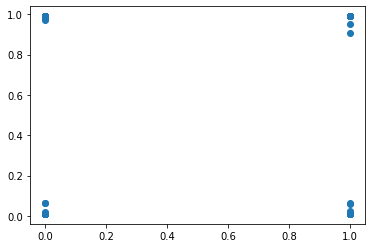

[[1.         0.21654368]
 [0.21654368 1.        ]]
Kfold: 2 ::: epoch: 100, loss: 0.21582692949210897, val loss: 0.8760169148445129
Kfold: 2 ::: epoch: 200, loss: 0.09897017172154259, val loss: 1.0745896100997925
Kfold: 2 ::: epoch: 300, loss: 0.11552902289173182, val loss: 1.143740713596344
Kfold: 2 ::: epoch: 400, loss: 0.03209855210255174, val loss: 1.5892914533615112
Kfold: 2 ::: epoch: 500, loss: 0.02060472181833842, val loss: 1.7389320731163025


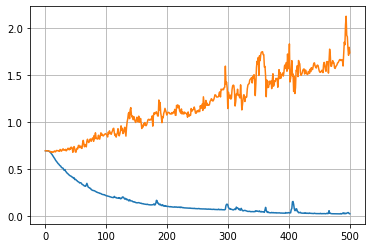

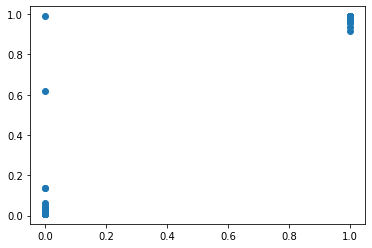

0.5
[[1.        0.9945895]
 [0.9945895 1.       ]]


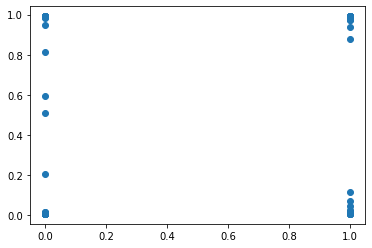

[[1.         0.09684793]
 [0.09684793 1.        ]]
Kfold: 3 ::: epoch: 100, loss: 0.24114129122565775, val loss: 0.8214244544506073
Kfold: 3 ::: epoch: 200, loss: 0.12731772617382162, val loss: 0.977888286113739
Kfold: 3 ::: epoch: 300, loss: 0.08504329271176282, val loss: 1.3098613023757935
Kfold: 3 ::: epoch: 400, loss: 0.08120919205248356, val loss: 1.6338289380073547
Kfold: 3 ::: epoch: 500, loss: 0.031451795359744746, val loss: 1.580736517906189


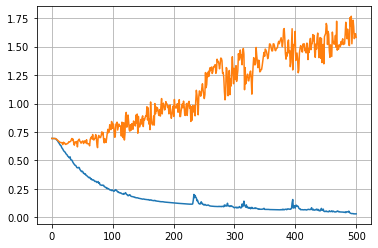

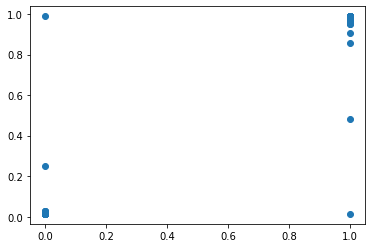

0.5
[[1.         0.99129766]
 [0.99129766 1.        ]]


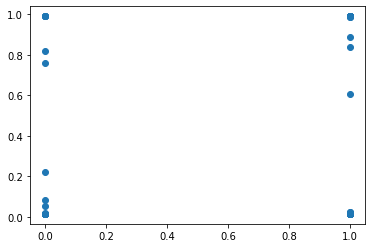

[[1.        0.2226951]
 [0.2226951 1.       ]]
Kfold: 4 ::: epoch: 100, loss: 0.2298039609895033, val loss: 0.9621132612228394
Kfold: 4 ::: epoch: 200, loss: 0.0992477610707283, val loss: 1.4145451784133911
Kfold: 4 ::: epoch: 300, loss: 0.05098338775775012, val loss: 1.5644174814224243
Kfold: 4 ::: epoch: 400, loss: 0.0489480781423695, val loss: 2.0827534198760986
Kfold: 4 ::: epoch: 500, loss: 0.0297628472394803, val loss: 1.9966543316841125


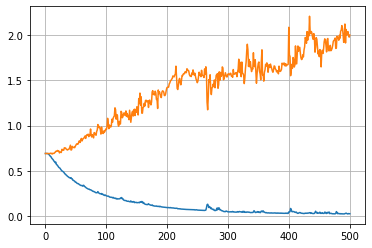

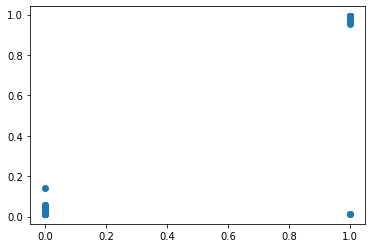

0.5
[[1.         0.99242528]
 [0.99242528 1.        ]]


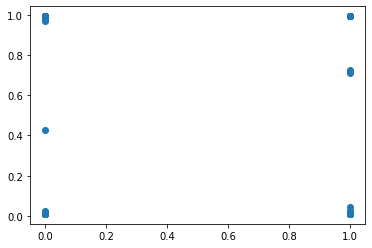

[[1.         0.02105976]
 [0.02105976 1.        ]]
Kfold: 5 ::: epoch: 100, loss: 0.22662478685379028, val loss: 0.743132472038269
Kfold: 5 ::: epoch: 200, loss: 0.10706343852421817, val loss: 0.9938660860061646
Kfold: 5 ::: epoch: 300, loss: 0.06523704638375956, val loss: 1.1616899967193604
Kfold: 5 ::: epoch: 400, loss: 0.0336969815852011, val loss: 1.3921685218811035
Kfold: 5 ::: epoch: 500, loss: 0.033445153056698686, val loss: 1.682183563709259


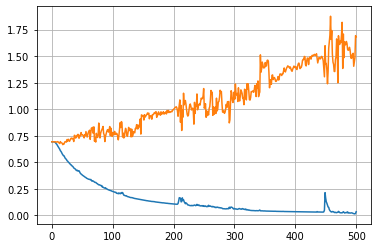

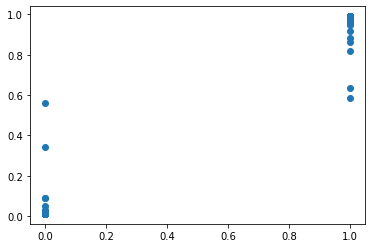

0.5
[[1.         0.99694555]
 [0.99694555 1.        ]]


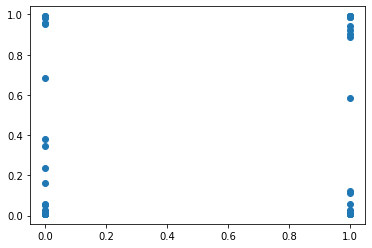

[[1.        0.2402675]
 [0.2402675 1.       ]]
Kfold: 6 ::: epoch: 100, loss: 0.2146826702005723, val loss: 0.7576778829097748
Kfold: 6 ::: epoch: 200, loss: 0.12075094177442439, val loss: 1.223666489124298
Kfold: 6 ::: epoch: 300, loss: 0.06373266612782198, val loss: 1.2198192477226257
Kfold: 6 ::: epoch: 400, loss: 0.05593103400486357, val loss: 1.5116877555847168
Kfold: 6 ::: epoch: 500, loss: 0.04640494626672829, val loss: 1.277592122554779


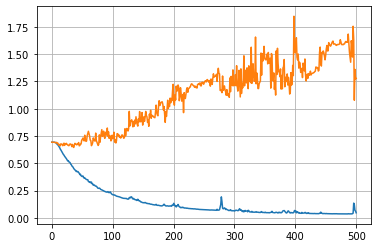

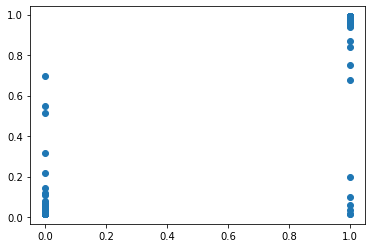

0.5
[[1.         0.97446596]
 [0.97446596 1.        ]]


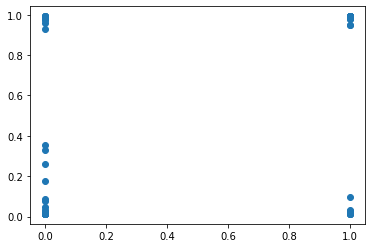

[[1.         0.23815075]
 [0.23815075 1.        ]]
Kfold: 7 ::: epoch: 100, loss: 0.23138918683809392, val loss: 0.8574614524841309
Kfold: 7 ::: epoch: 200, loss: 0.11821803888853859, val loss: 1.0068966746330261
Kfold: 7 ::: epoch: 300, loss: 0.0687049327089506, val loss: 1.3684371709823608
Kfold: 7 ::: epoch: 400, loss: 0.042155072421712035, val loss: 1.8131788969039917
Kfold: 7 ::: epoch: 500, loss: 0.029103464173043474, val loss: 2.0651535987854004


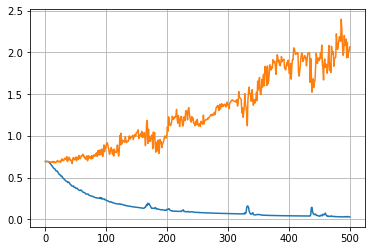

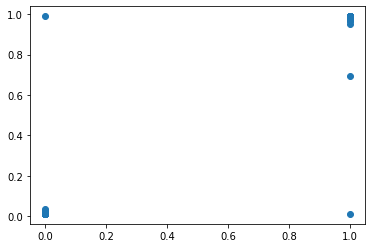

0.5
[[1.         0.99227068]
 [0.99227068 1.        ]]


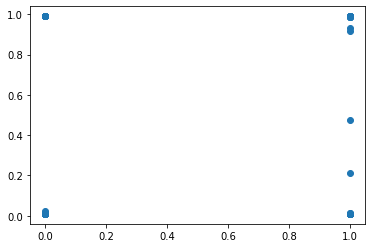

[[1.         0.11642143]
 [0.11642143 1.        ]]
Kfold: 8 ::: epoch: 100, loss: 0.21853201792520635, val loss: 0.849957138299942
Kfold: 8 ::: epoch: 200, loss: 0.11651156053823583, val loss: 0.9783402681350708
Kfold: 8 ::: epoch: 300, loss: 0.06965627696584253, val loss: 1.310442566871643
Kfold: 8 ::: epoch: 400, loss: 0.032620056039270234, val loss: 1.43002450466156
Kfold: 8 ::: epoch: 500, loss: 0.022714598487843487, val loss: 1.574589192867279


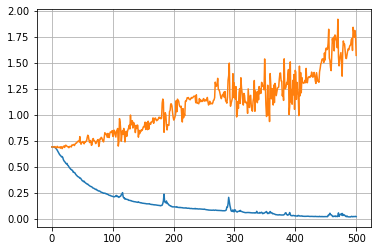

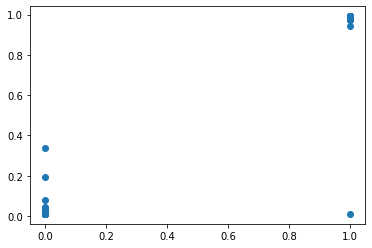

0.5
[[1.         0.99567713]
 [0.99567713 1.        ]]


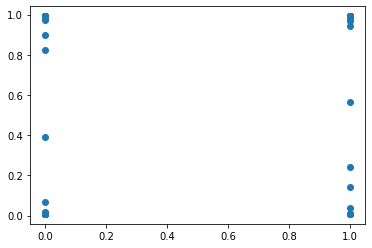

[[1.         0.29025586]
 [0.29025586 1.        ]]
Kfold: 9 ::: epoch: 100, loss: 0.23264322649030125, val loss: 1.0207352042198181
Kfold: 9 ::: epoch: 200, loss: 0.10849644243717194, val loss: 1.2368436455726624
Kfold: 9 ::: epoch: 300, loss: 0.06996694645460914, val loss: 1.441495954990387
Kfold: 9 ::: epoch: 400, loss: 0.04994933887877885, val loss: 1.3023545742034912
Kfold: 9 ::: epoch: 500, loss: 0.02840898826937465, val loss: 1.7705174684524536


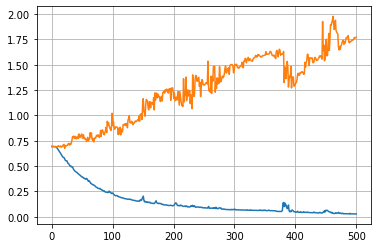

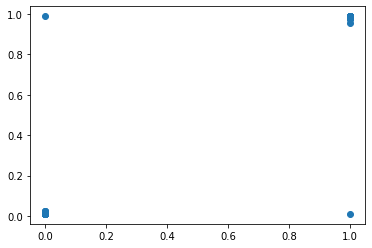

0.5
[[1.        0.9924602]
 [0.9924602 1.       ]]


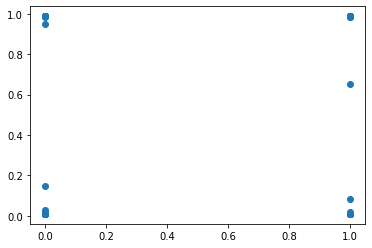

[[1.         0.15055234]
 [0.15055234 1.        ]]
Kfold: 10 ::: epoch: 100, loss: 0.24330120051608367, val loss: 0.891219973564148
Kfold: 10 ::: epoch: 200, loss: 0.10563694773351445, val loss: 1.205876111984253
Kfold: 10 ::: epoch: 300, loss: 0.07584383930353557, val loss: 1.3814383745193481
Kfold: 10 ::: epoch: 400, loss: 0.049041500424637514, val loss: 1.524164617061615
Kfold: 10 ::: epoch: 500, loss: 0.029228702625807595, val loss: 2.025173604488373


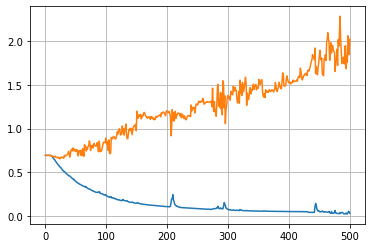

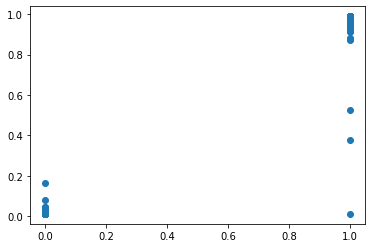

0.5
[[1.         0.99364769]
 [0.99364769 1.        ]]


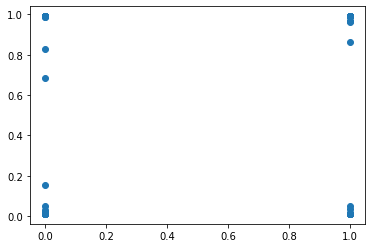

[[1.         0.10058791]
 [0.10058791 1.        ]]


In [13]:
# 64 4 1 0.1 0.1
test_pred,test_label = train_model(data_aal,data_label,epochs=500,n_splits=10)

array([[1.        , 0.46138277],
       [0.46138277, 1.        ]])

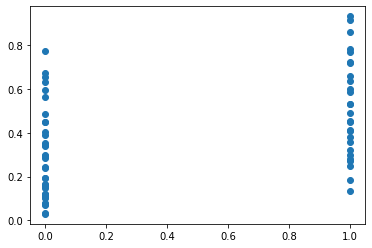

In [11]:
plt.scatter(test_label[:,0],test_pred[0,:,0])
np.corrcoef(test_label[:,0],test_pred[0,:,0])

array([[1.        , 0.46828975],
       [0.46828975, 1.        ]])

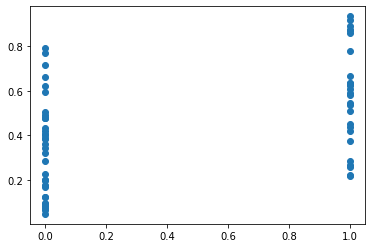

In [12]:
plt.scatter(test_label[:,0],test_pred[1,:,0])
np.corrcoef(test_label[:,0],test_pred[1,:,0])

array([[1.        , 0.42694881],
       [0.42694881, 1.        ]])

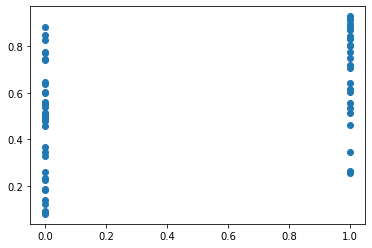

In [13]:
plt.scatter(test_label[:,0],test_pred[2,:,0])
np.corrcoef(test_label[:,0],test_pred[2,:,0])

array([[1.       , 0.4426225],
       [0.4426225, 1.       ]])

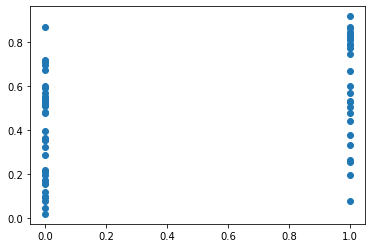

In [14]:
plt.scatter(test_label[:,0],test_pred[3,:,0])
np.corrcoef(test_label[:,0],test_pred[3,:,0])

array([[1.        , 0.44973484],
       [0.44973484, 1.        ]])

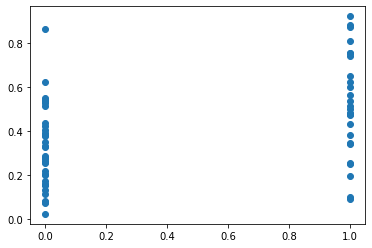

In [15]:
plt.scatter(test_label[:,0],test_pred[4,:,0])
np.corrcoef(test_label[:,0],test_pred[4,:,0])

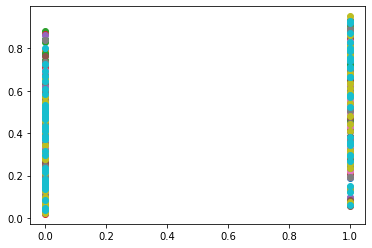

In [16]:
plt.scatter(test_label[:,0],test_pred[0,:,0])
plt.scatter(test_label[:,0],test_pred[1,:,0])
plt.scatter(test_label[:,0],test_pred[2,:,0])
plt.scatter(test_label[:,0],test_pred[3,:,0])
plt.scatter(test_label[:,0],test_pred[4,:,0])
plt.scatter(test_label[:,0],test_pred[5,:,0])
plt.scatter(test_label[:,0],test_pred[6,:,0])
plt.scatter(test_label[:,0],test_pred[7,:,0])
plt.scatter(test_label[:,0],test_pred[8,:,0])
plt.scatter(test_label[:,0],test_pred[9,:,0])

array([[1.        , 0.48093272],
       [0.48093272, 1.        ]])

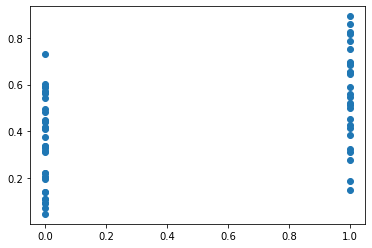

In [17]:
test_pred_mean = test_pred.mean(axis=0)
plt.scatter(test_label[:,0],test_pred_mean[:,0])
np.corrcoef(test_label[:,0],test_pred_mean[:,0])
#0.46427031

In [18]:
from sklearn.metrics import r2_score

print('r^2 train data: ', r2_score(test_label[:,0],test_pred_mean[:,0]))

r^2 train data:  0.2297786305298044


In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(test_label,test_pred_mean[:,0])

LinearRegression()

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'age')

Text(0, 0.5, 'age predict')

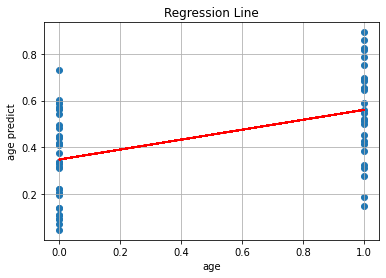

In [20]:
plt.scatter(test_label[:,0],test_pred_mean[:,0])         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(test_label[:,0], lr.predict(test_label), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')               # 図のタイトル
plt.xlabel('age') # x軸のラベル
plt.ylabel('age predict')    # y軸のラベル
plt.grid()                                 # グリッド線を表示

plt.show()                                 # 図の表示

In [21]:
diff = test_pred_mean[:,0] - lr.predict(test_label)

In [22]:
_, _, _, label_ = train_test_split(data_aal,data_label, train_size = 0.9 ,shuffle=False)

array([[1.        , 0.17264722],
       [0.17264722, 1.        ]])

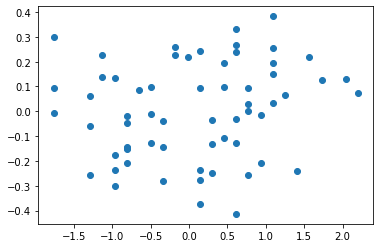

In [23]:
plt.scatter(label_[:,2],diff)
np.corrcoef(label_[:,2],diff)

In [ ]:
a = 0
for i,c in enumerate(test_label[:,0]):
    if c == 1:
        if test_pred_mean[:,0][i] >= 0.5:
            a += 1
    else:
        if test_pred_mean[:,0][i] < 0.5:
            a += 1
a/len(test_label[:,0])

In [24]:
np.mean(test_pred_mean[:,0])

0.43979266

In [25]:
np.mean(test_label[:,0])

0.43548387096774194

In [26]:
def test_pred_01(test_pred = test_pred):
    test_pred_all = []
    for i in range(test_pred.shape[0]):
        test_pred_ = []
        for j in range(test_pred.shape[1]):
            pred = test_pred[i,j][0]
            if pred < 0.5:
                pred = 0
            else:
                pred = 1
            test_pred_.append([pred])
        test_pred_all.append(test_pred_)
    return np.array(test_pred_all)

array([[1.        , 0.47812191],
       [0.47812191, 1.        ]])

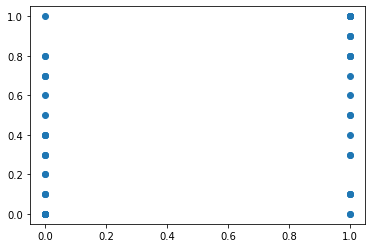

In [27]:
test_pred_ = test_pred_01()
test_pred_mean_ = test_pred_.mean(axis=0)
plt.scatter(test_label[:,0],test_pred_mean_[:,0])
np.corrcoef(test_label[:,0],test_pred_mean_[:,0])
#0.46427031